In [14]:
import os

import numpy as np
from tqdm import tqdm
from fidelity_simulation import FidelitySimulation
from pulse import RectangularReadoutPulse
from floquet_analysis.transmon_resonator_fitter import TransmonResonatorFitter
import matplotlib.pyplot as plt

from fidelity_analysis.utils import setup_plotting, S2pUtils
from fidelity_analysis.pulse import Pulse

setup_plotting()

In [15]:
# Measured frequencies GHz
f01_meas = 3.845965050
f12_meas = 3.602264855
alpha = f12_meas - f01_meas

fr0_meas = 6.065852884
fr1_meas = 6.064931745
fr2_meas = 6.064094073

kappa_div2pi = 0.55e-3

fitter = TransmonResonatorFitter(f01_meas, f12_meas, fr0_meas, fr1_meas, fr2_meas)

EJ_fitted, EC_fitted, fr_fitted, g_fitted = fitter.fit_parameters()

fitter.print_results()

Initial guess for [EJ, EC, fr, g]: [8.578861527050124, 0.24370019500000017, 6.0653923145, np.float64(0.09103399089132334)]

--- Fitting Results ---
Fitted EJ: 9.8266 GHz
Fitted EC: 0.2106 GHz
Fitted Resonator Freq (bare, f_r): 6.0650 GHz
Fitted Coupling Strength (g): 0.1017 GHz

Fitted Frequencies (from model with fitted parameters):
  Qubit f01: 3.8460 GHz
  Qubit f12: 3.6023 GHz
  Resonator freq @ Qubit |0>: 6.0650 GHz
  Resonator freq @ Qubit |1>: 6.0650 GHz
  Resonator freq @ Qubit |2>: 6.0650 GHz

Measured Frequencies (input data):
  Qubit f01: 3.8460 GHz
  Qubit f12: 3.6023 GHz
  Resonator freq @ Qubit |0>: 6.0659 GHz
  Resonator freq @ Qubit |1>: 6.0649 GHz
  Resonator freq @ Qubit |2>: 6.0641 GHz

Total Squared Error: 1.55e-06


In [16]:
current_path = os.path.abspath("")
data_dir_path = os.path.join(current_path, "data")
images_dir_path = os.path.join(current_path, "images")

In [17]:
f_pulse = fr0_meas * 10 ** 9  # Hz

pulse_length = 2 * 10 ** (-6)  # s

pulse_samples_number = 2 ** 17

rect_readout_pulse = RectangularReadoutPulse(
    carrier_frequency=f_pulse,
    pulse_duration=pulse_length,
    pulse_power_dbm=-123,
    total_signal_time=1.5 * pulse_length,
    pulse_samples_number=pulse_samples_number,
)

rect_readout_pulse.plot_pulse()

 /Users/user/PycharmProjects/qubit_readout_simulation/fidelity_analysis/pulse.py: 217

In [18]:
delta_arr = -1 * np.linspace(0.5, 6, 500)

In [19]:
def chi(delta_val):
    return g_fitted ** 2 / delta_val * (1 / (1 + delta_val / alpha))

In [20]:
fidelity = []

Q = f_pulse * 1e-9 / kappa_div2pi

for delta in (pbar := tqdm(delta_arr)):
    state_0_f = f_pulse + chi(delta) * 1e9
    state_1_f = f_pulse - chi(delta) * 1e9
    state_0 = S2pUtils.create_resonator_S21(state_0_f, Q, Q, np.linspace(state_0_f * 0.995, state_0_f * 1.005, 5000))
    state_1 = S2pUtils.create_resonator_S21(state_1_f, Q, Q, np.linspace(state_1_f * 0.995, state_1_f * 1.005, 5000))

    fidelity_simulation = FidelitySimulation(
        s_parameters_file_state_0=state_0,
        s_parameters_file_state_1=state_1,
        readout_pulse=rect_readout_pulse,
        IQ_projection_frequency=6.2e9,  # f_fi = 200MHz
        num_iterations=500,
        readout_dt=1e-9,
        plot_pulses=False,
        plot_result=False,
        disable_progress_bar=True,
    )

    result = fidelity_simulation.run()
    fidelity.append(result)
    pbar.set_postfix_str(f"fidelity = {result}, delta = {delta}")

100%|██████████| 500/500 [31:28<00:00,  3.78s/it, fidelity = 0.836, delta = -6.0]               


100%|██████████| 2/2 [00:00<00:00, 421.16it/s]


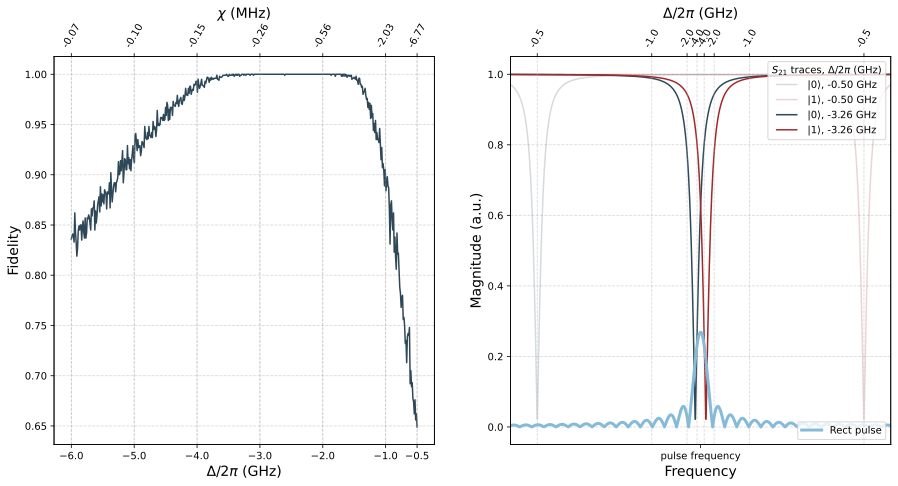

In [29]:
fig, axs_12 = plt.subplots(1, 2, figsize=(15, 7), dpi=300)

delta_for_plot = np.array([-6, -5, -4, -3, -2, -1, -0.5])
delta_for_plot1 = np.array([-4, -2, -1, -0.5])

axs_12[0].set_xlabel(r'$\Delta/2\pi$ (GHz)')
axs_12[0].set_ylabel('Fidelity')

axs_12[0].plot(delta_arr, fidelity)
axs_12[0].set_xticks(delta_for_plot)

ax1 = axs_12[0].twiny()
ax1.set_xlim(axs_12[0].get_xlim())
ax1.set_xticks(delta_for_plot)

ax1.set_xticklabels(["%.2f" % round(x * 1000, 2) for x in chi(delta_for_plot)], rotation=60)
ax1.set_xlabel(r"$\chi$ (MHz)", labelpad=10)

delta_indexes = [0, 30]
delta_arr_some = delta_arr[::int(len(delta_arr)/2)]


def plot_file(delta, iteration_n, state):
    shift = chi(delta) * 1e9 * (1 if state == 0 else -1)
    state_f = f_pulse + shift

    network = S2pUtils.create_resonator_S21(state_f, Q, Q, np.linspace(state_f * 0.995, state_f * 1.005, 5000))

    frequencies_ghz = network.f
    s21_complex = network.s[:, 1, 0]

    if state == 0:
        base_color = 'C0'
    elif state == 1:
        base_color = 'C1'
    else:
        base_color = 'black'  # fallback in case of unexpected state

    # Transparency from 1.0 (first) to 0.6 (last)
    alpha = 0.2 + (iteration_n / (len(delta_arr_some) - 1)) * 0.8

    label_text = None
    if iteration_n == len(delta_arr_some) - 1 or iteration_n == 0:
        label_text = (
                rf"$\; |{state}\rangle$, "
                + "%.2f" % round(delta, 2) + " GHz"
        )

    axs_12[1].plot(
        frequencies_ghz,
        np.abs(s21_complex),
        color=base_color,
        label=label_text,
        alpha=alpha
    )


# Loop over all deltas
for i, delta in tqdm(enumerate(delta_arr_some), total=len(delta_arr_some)):
    # path0 = os.path.join(simulation_path, f"{(delta)}_0.s2p")
    plot_file(delta, i, 0)

    # path1 = os.path.join(simulation_path, f"{delta}_1.s2p")
    plot_file(delta, i, 1)

# Add pulse overlay
t_signal = rect_readout_pulse.t_signal
dt = rect_readout_pulse.t_signal_times[1] - rect_readout_pulse.t_signal_times[0]
edges = (f_pulse * 0.99, f_pulse * 1.01)
f_signal, f_signal_frequencies = Pulse.to_frequency_domain(
    t_signal, dt, pulse_samples_number, edges, force_use_czt=True
)

axs_12[1].plot(
    f_signal_frequencies,
    6e11 * np.abs(f_signal),
    c='C2',
    label="Scaled Rect Readout pulse",
    linewidth=3
)

axs_12[1].set_xlabel('Frequency')
axs_12[1].set_ylabel('Magnitude (a.u.)')
axs_12[1].set_xlim(f_pulse * 0.9987, f_pulse * 1.0013)

handles, labels = axs_12[1].get_legend_handles_labels()
s21_handles = handles[:-1]
s21_labels = labels[:-1]
pulse_handle = handles[-1]

leg1 = axs_12[1].legend(
    s21_handles, s21_labels,
    title=r"$S_{21}$ traces, $\Delta/2\pi$ (GHz)",
    loc="upper right", frameon=True
)

# Second legend (pulse only)
axs_12[1].legend(
    [pulse_handle], ["Rect pulse"],
    loc="lower right", frameon=True
)
axs_12[1].add_artist(leg1)

axs_12[1].set_xticks([f_pulse])
axs_12[1].set_xticklabels(["pulse frequency"])

ax2 = axs_12[1].twiny()
ax2.set_xlim(axs_12[1].get_xlim())
ax2.set_xticks(np.concatenate((-chi(delta_for_plot1), chi(delta_for_plot1))) * 1e9 + f_pulse)

ax2.set_xticklabels(np.concatenate((delta_for_plot1, delta_for_plot1)), rotation=60)
ax2.set_xlabel(r'$\Delta/2\pi$ (GHz)', labelpad=10)

axs_12[1].xaxis.grid(False, which='both')

ax1.xaxis.set_label_coords(0.5, 1.1)
ax2.xaxis.set_label_coords(0.5, 1.1)

plt.savefig(os.path.join(images_dir_path, "fidelity_VS_detuning.pdf"), bbox_inches='tight')
plt.savefig(os.path.join(images_dir_path, "fidelity_VS_detuning.png"), bbox_inches='tight')
plt.show()